# Optimal wind angle while sailing close hauled

## Executive summary

I recently ran into a (good-natured) argument on which true wind angle (TWA) should one sail when the target cannot be reached without tacking. Say, for example your target lies 20° off the wind. 

Some numerical analysis below, and it shows that:

**For any target that requires you to tack to get there, on both tacks you should sail the course that maximizes the Wind VMG. Give or take a few degrees.**

(It also shows that I was right and my crewmates were wrong.)

## Content / steps taken

1. Define the boat. Actually it's just the boat polars
2. Knowing the polars, define a function that calculates route duration from start to finish via a tack location.
  * Some samples of the function output provided
3. For given start and finish location, minimize the function value by choosing right the tack location.
4. Find the best tack location for finish locations on 180-degree span from luff (TWA 0°) to dead run (TWA 180°)
5. Show results

The code for this notebook is hidden in nbviewer. You can reveal it by clicking the "</>" icon at top right-hand corner. 

Harri Kinnunen / Hitsaamo / 2018

In [1]:
import torch 
import torch.autograd as autograd 
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
from render import render_isocurves
from render import u2g


# Boat setup
Only boat polars matter here. These are from an imaginary boat, but have the generic characteristics of the polars:
* Cannot sail upwind
* Max boat speed around TWA 120
* Going directly downwind is slower than gybing

The boat speeds on the polars are **scaled down** so that taking the trip from start to finish on the TWA that maximizes boat speed takes 1 time unit. Other routes (say TWA 45°) could take something like 3 time units. 



In [2]:
# Somewhat realistic boat polars
# Based on values from http://www.oppedijk.com/sailing/create-polar-diagram for 10kts wind
# Added speed value of 0.01 kts for upwind. Just to avoid some eventual "divide by zero" or whatnot. 
twa_base_deg = np.array([0,    44.5, 52,   60,   75,   90,   110,  120, 135,  150,  180])
speed_base = np.array([0.1,  4.11, 6.32, 6.66, 7.08, 7.10, 7.10, 7.5, 6.55, 5.83, 3.5])
twa_base_rad = np.deg2rad(twa_base_deg)
speed_norm = speed_base/7.1
polar_estimate = np.polyfit(twa_base_rad, speed_norm, 4)
#print(polar_estimate)

def speed_by_angle_rad(angle_rad):
    # Keyed in the polar esimates from np.polyfit() results
    # Mildly fudged to make sure that the max(boat_speed) = 1
    return (0.02257168*angle_rad**4 - 0.13148233*angle_rad**3 - 0.09179456*angle_rad**2 + 1.04220943*angle_rad + 0.00745035)/1.0572131119088066 


In [3]:
# Find the angle that maximizes the upwind component of the boat vector
# This is the TWA where (according to common consensus) the fastest Wind VMG can be achieved

upwind_max_vmg_angle = torch.tensor(44.0, requires_grad = True) # First guess
lr = 10
for j in range(0,10000):
    y_component_speed =  torch.cos(upwind_max_vmg_angle * math.pi / 180) * speed_by_angle_rad(upwind_max_vmg_angle * math.pi / 180)
    y_component_speed.backward()
    #print(upwind_max_vmg_angle, upwind_max_vmg_angle.grad)
    upwind_max_vmg_angle.requires_grad = False
    upwind_max_vmg_angle += lr * upwind_max_vmg_angle.grad
    upwind_max_vmg_angle.requires_grad = True
    upwind_max_vmg_angle.grad.zero_()

# Find the angle that maximizes the downwind component of the boat vector
# This is the TWA where (according to common consensus) the fastest downwind Wind VMG can be achieved

downwind_min_vmg_angle = torch.tensor(145.0, requires_grad = True) # First guess
lr = 10
for j in range(0,10000):
    y_component_speed =  torch.cos(downwind_min_vmg_angle * math.pi / 180) * speed_by_angle_rad(downwind_min_vmg_angle * math.pi / 180)
    y_component_speed.backward()
    #print(upwind_max_vmg_angle, upwind_max_vmg_angle.grad)
    downwind_min_vmg_angle.requires_grad = False
    downwind_min_vmg_angle -= lr * downwind_min_vmg_angle.grad
    downwind_min_vmg_angle.requires_grad = True
    downwind_min_vmg_angle.grad.zero_()


TWA that maximizes Wind VMG: 44.67°, Boat speed at that angle: 0.67, Upwind component: 0.48 
Downwind TWA that minimizes Wind VMG: 148.25°, Boat speed at that angle: 0.78, Downwind component: -0.66 


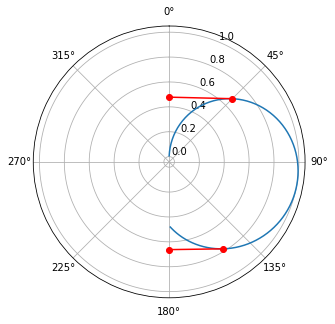

In [4]:
# Render the polars
plt.rcParams['figure.figsize'] = [5, 5] 
full_circle = np.arange(0,180,1)
speeds = speed_by_angle_rad(np.deg2rad(full_circle))

half_circle = speed_by_angle_rad(np.linspace(0, np.pi, 180))

plr = plt.subplot(111, polar=True)
plr.plot(np.deg2rad(full_circle), speeds)

plr.set_theta_zero_location("N")
plr.set_theta_direction(-1)

plr.plot([0,upwind_max_vmg_angle * math.pi / 180], [torch.cos(upwind_max_vmg_angle * math.pi / 180) * speed_by_angle_rad(upwind_max_vmg_angle * math.pi / 180),speed_by_angle_rad(upwind_max_vmg_angle * math.pi / 180)], 'ro-')
plr.plot([math.pi,downwind_min_vmg_angle * math.pi / 180], [-torch.cos(downwind_min_vmg_angle * math.pi / 180) * speed_by_angle_rad(downwind_min_vmg_angle * math.pi / 180),speed_by_angle_rad(downwind_min_vmg_angle * math.pi / 180)], 'ro-')

print("TWA that maximizes Wind VMG: {0:.2f}°, Boat speed at that angle: {1:.2f}, Upwind component: {2:.2f} ".
      format(upwind_max_vmg_angle.item(), 
      speed_by_angle_rad(upwind_max_vmg_angle * math.pi / 180).item(), 
      (torch.cos(upwind_max_vmg_angle * math.pi / 180) * speed_by_angle_rad(upwind_max_vmg_angle * math.pi / 180)).item()))

print("Downwind TWA that minimizes Wind VMG: {0:.2f}°, Boat speed at that angle: {1:.2f}, Downwind component: {2:.2f} "
      .format(downwind_min_vmg_angle.item(), 
      speed_by_angle_rad(downwind_min_vmg_angle * math.pi / 180).item(), 
      (torch.cos(downwind_min_vmg_angle * math.pi / 180) * speed_by_angle_rad(downwind_min_vmg_angle * math.pi / 180)).item()))


Boat polars. Also marked the max/min Wind VMG values. 

TWA that maximizes Wind VMG is 44.67°. 

Downwind TWA that minimizes Wind VMG is 148.25°.

# Core "business rule"
The function `leg_duration` calculates the total duration of sailing from start to finish via a tack point. The target could be directly upwind ("north") or it could be any compass bearing away from north.

The function is just:
* Given a tack location ("first tack"), calculate the TWA on that tack. Get the boat speed from the polars and divide the length of the first tack by boat speed. You get the first tack duration.
* The second tack goes from tack location to target. Do the same math to get the duration for second tack. 
* Add up first tack duration and second tack duration and return the result

```
def leg_duration(origin, first_tack, target):

    north = torch.tensor([1.,0.]) #This is where the wind comes from

    second_tack = target - first_tack

    first_tack_angle = angle_between(north, first_tack-origin)
    first_tack_distance = torch.norm(origin-first_tack)
    first_tack_duration = first_tack_distance / speed_by_angle_rad(first_tack_angle)

    second_tack_angle = angle_between(north, second_tack)
    second_tack_distance = torch.norm(second_tack)
    second_tack_duration = second_tack_distance / speed_by_angle_rad(second_tack_angle)

    total = first_tack_duration + second_tack_duration
    
    return total
```


In [5]:
def angle_between(v1, v2): 
    v1_u = v1/torch.norm(v1) 
    v2_u = v2/torch.norm(v2) 
    
    # Need to avoid -1 and +1, as torch yields a gradient of "NaN" for such acos()
    inner_angle = torch.acos(torch.clamp(torch.dot(v1_u, v2_u), -0.9999999, 0.9999999))

    return inner_angle


def leg_duration(origin, first_tack, target):

    north = torch.tensor([1.,0.]) #This is where the wind comes from

    second_tack = target - first_tack

    first_tack_angle = angle_between(north, first_tack-origin)
    first_tack_distance = torch.norm(origin-first_tack)
    first_tack_duration = first_tack_distance / speed_by_angle_rad(first_tack_angle)

    second_tack_angle = angle_between(north, second_tack)
    second_tack_distance = torch.norm(second_tack)
    second_tack_duration = second_tack_distance / speed_by_angle_rad(second_tack_angle)

    total = first_tack_duration + second_tack_duration
    
    return total 



Let's visualize the results to make sure we're getting meaningful values from it.


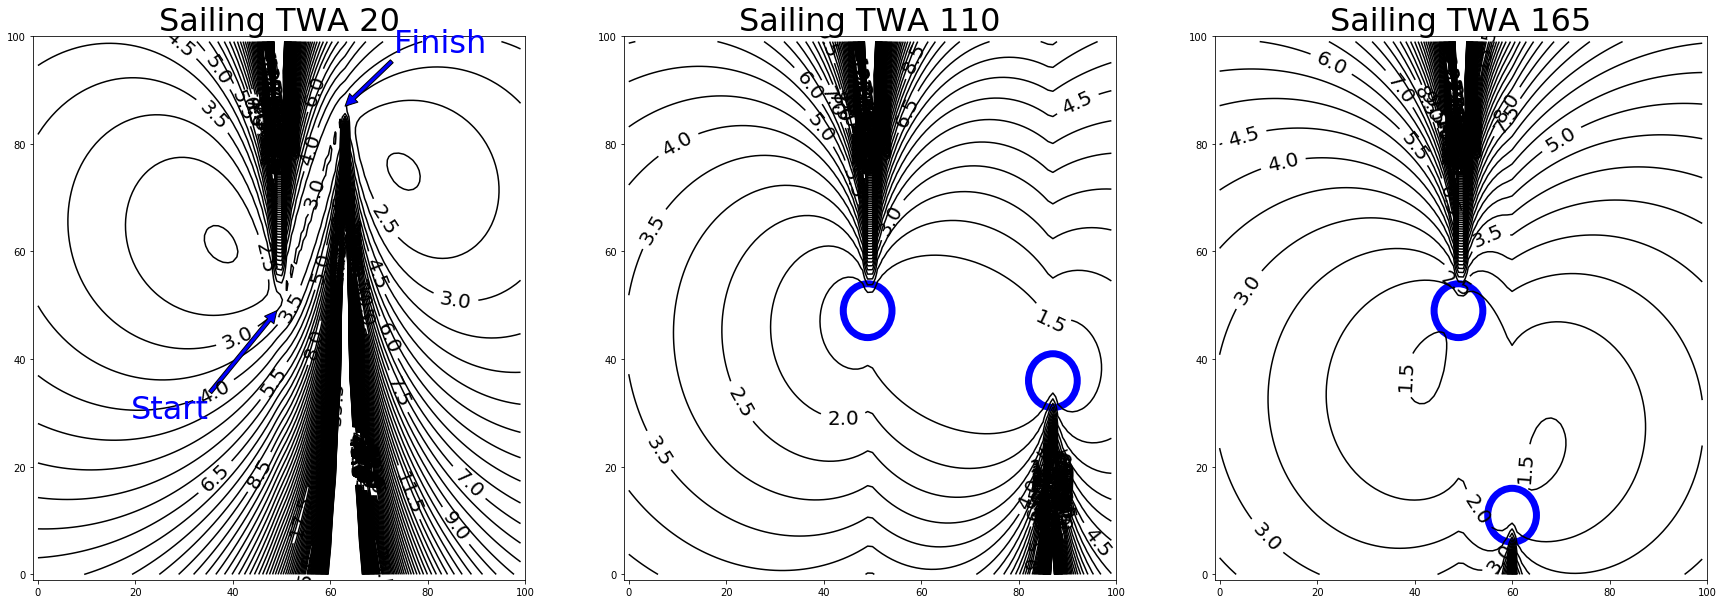

In [6]:
resolution = 100
origin = torch.tensor([.0,.0])


plt.rcParams['figure.figsize'] = [30, 10] 
fig, axii = plt.subplots(1,3)
for a in axii: # Yea, it's really "axes"
    a.set_xlim(-1,resolution)
    a.set_ylim(-1,resolution)

###
target_angle = 20
title = "Sailing TWA {0:.0f}".format(target_angle)
ax = 0
a = torch.tensor(np.deg2rad(target_angle))
target = origin + torch.tensor( [ torch.cos(a), torch.sin(a)]) 
axii[ax].set_title(title, fontsize=32)
render_isocurves(axii[ax], origin, target, resolution, leg_duration)
axii[0].annotate('Start', xy=u2g(origin, resolution), xytext=u2g(origin, resolution)+np.array([-30,-20]), arrowprops=dict(facecolor='blue'),fontsize=32, color='blue')
axii[0].annotate('Finish', xy=u2g(target, resolution), xytext=u2g(target, resolution)+np.array([10,10]), arrowprops=dict(facecolor='blue'),fontsize=32, color='blue')
#axii[0].annotate('Tack', xy=np.array([75,75]), xytext=np.array([80,50]), arrowprops=dict(facecolor='blue'),fontsize=32, color='blue')

###
target_angle = 110
title = "Sailing TWA {0:.0f}".format(target_angle)
ax = 1
a = torch.tensor(np.deg2rad(target_angle))
target = origin + torch.tensor( [ torch.cos(a), torch.sin(a)]) 
axii[ax].set_title(title, fontsize=32)
render_isocurves(axii[ax], origin, target, resolution, leg_duration)
axii[ax].add_patch(plt.Circle(u2g(origin, resolution), radius=5, linewidth=7,edgecolor='blue',facecolor='none'))
axii[ax].add_patch(plt.Circle(u2g(target, resolution), radius=5, linewidth=7,edgecolor='blue',facecolor='none'))

###
target_angle = 165
title = "Sailing TWA {0:.0f}".format(target_angle)
ax = 2
a = torch.tensor(np.deg2rad(target_angle))
target = origin + torch.tensor( [ torch.cos(a), torch.sin(a)]) 
axii[ax].set_title(title, fontsize=32)
render_isocurves(axii[ax], origin, target, resolution, leg_duration)
axii[ax].add_patch(plt.Circle(u2g(origin, resolution), radius=5, linewidth=7,edgecolor='blue',facecolor='none'))
_ = axii[ax].add_patch(plt.Circle(u2g(target, resolution), radius=5, linewidth=7,edgecolor='blue',facecolor='none'))


In the charts above:
* You sail out from the center of the chart towards the location shown.
* The distance from start to finish is 1.
* The isocurves show how long the total route would take if you tacked there. Remember that you boat top speed is 1.

Looking at the **TWA 20** chart, you start from the center and want reach the finish spot. You need to tack. If you tack inside the isocurve marked "2.5", you will arrive at goal in 2.5 time units or less. If you tack inside the circle marked "3.0", you will arrive at goal in 3.0 time units or less. And so on...

Looking at the **TWA 120** chart, you "tack" inside the "1.5" isocurve. This is probably just a straight course from start to finish. 

Looking at the **TWA 165** chart, you gybe inside the "1.5" isocurve in for the fastest track.


Intuitively, the tack location that minimizes the track duration in the charts above is somewhere inside the smallest-valued isocurves.

## Finding the best tack location 
The best tack location for a given target bearing is the one that minimizes the value of `leg_duration`. 


In [7]:
'''
Gradient descent on the total duration with respect to tack location. 
We'll start the descent from a the right-hand side of the chart as we want to find 
the tack locations to "east" of the starting position. The tracks starting with starboard tack are 
just mirror images of port tack ones -- or at least that's the assumption we'll live with.
'''

origin = torch.tensor([0.0,0], requires_grad = False)

north = torch.tensor([1.,0.])

target_angles = np.arange(0,181,1)
tack_locations = torch.zeros(181,2)
tack_locations.requires_grad=False

lr = 0.001
seek_iterations = 1000

for i, target_angle in enumerate(target_angles): 

    a = torch.tensor(np.deg2rad(target_angle))
    target = torch.tensor([torch.cos(a), torch.sin(a)]) 

    #First tack is just guess at this point
    first_tack = torch.tensor([0.0, 1.0])
    first_tack.requires_grad = True

    # Brute force gradient descent
    for j in range(1, seek_iterations):
        duration = leg_duration(origin, first_tack, target)
        duration.backward()

        first_tack.requires_grad = False
        first_tack -= lr * torch.clamp(first_tack.grad, -1.0, 1)
        first_tack.requires_grad = True

        first_tack.grad.zero_()
    
    first_tack.requires_grad = False
    tack_locations[i,:] = first_tack.clone()
    #print(target_angle)
    

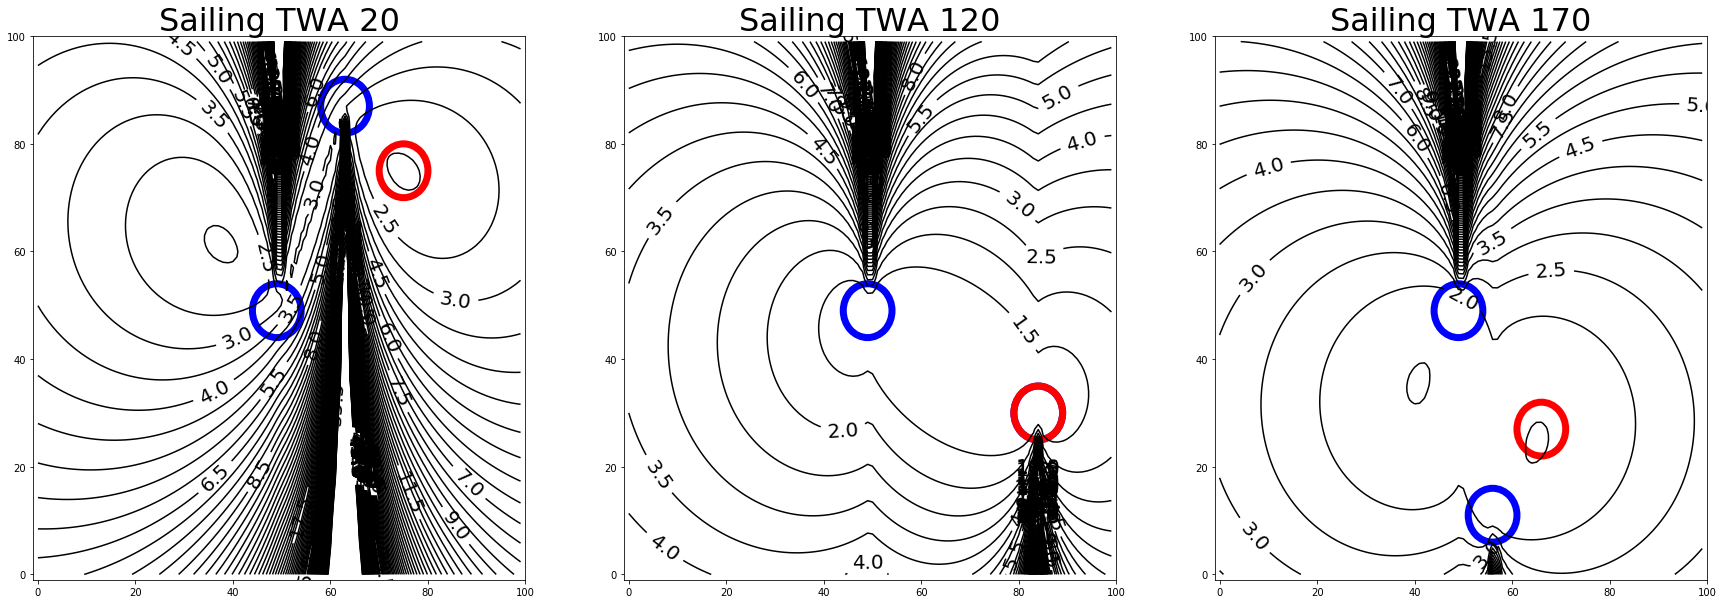

In [8]:
plt.rcParams['figure.figsize'] = [30, 10] 
fig, axii = plt.subplots(1,3)
for a in axii: 
    a.set_xlim(-1,resolution)
    a.set_ylim(-1,resolution)

#TWA 20
target_angle = 20
title = "Sailing TWA {0:.0f}".format(target_angle)
ax = 0
a = torch.tensor(np.deg2rad(target_angle))
target = origin + torch.tensor( [ torch.cos(a), torch.sin(a)]) 
axii[ax].set_title(title, fontsize=32)
render_isocurves(axii[ax], origin, target, resolution, leg_duration)
axii[ax].add_patch(plt.Circle(u2g(origin, resolution), radius=5, linewidth=7,edgecolor='blue',facecolor='none'))
axii[ax].add_patch(plt.Circle(u2g(target, resolution), radius=5, linewidth=7,edgecolor='blue',facecolor='none'))
axii[ax].add_patch(plt.Circle(u2g(tack_locations[target_angle,:], resolution), radius=5, linewidth=7,edgecolor='red',facecolor='none'))

#TWA 20
target_angle = 120
title = "Sailing TWA {0:.0f}".format(target_angle)
ax = 1
a = torch.tensor(np.deg2rad(target_angle))
target = origin + torch.tensor( [ torch.cos(a), torch.sin(a)]) 
axii[ax].set_title(title, fontsize=32)
render_isocurves(axii[ax], origin, target, resolution, leg_duration)
axii[ax].add_patch(plt.Circle(u2g(origin, resolution), radius=5, linewidth=7,edgecolor='blue',facecolor='none'))
axii[ax].add_patch(plt.Circle(u2g(target, resolution), radius=5, linewidth=7,edgecolor='blue',facecolor='none'))
axii[ax].add_patch(plt.Circle(u2g(tack_locations[target_angle,:], resolution), radius=5, linewidth=7,edgecolor='red',facecolor='none'))

#TWA 170
target_angle = 170
title = "Sailing TWA {0:.0f}".format(target_angle)
ax = 2
a = torch.tensor(np.deg2rad(target_angle))
target = origin + torch.tensor( [ torch.cos(a), torch.sin(a)]) 
axii[ax].set_title(title, fontsize=32)
render_isocurves(axii[ax], origin, target, resolution, leg_duration)
axii[ax].add_patch(plt.Circle(u2g(origin, resolution), radius=5, linewidth=7,edgecolor='blue',facecolor='none'))
axii[ax].add_patch(plt.Circle(u2g(target, resolution), radius=5, linewidth=7,edgecolor='blue',facecolor='none'))
_ = axii[ax].add_patch(plt.Circle(u2g(tack_locations[target_angle,:], resolution), radius=5, linewidth=7,edgecolor='red',facecolor='none'))


The **red circle** marks the optimal tack point found. 

Looks good. For the TWA 120 track, there is no real tack. It's just sailing directly from start to finish.


In [9]:
# Housekeeping
# We'll rework all the results into numpy arrays for charting

targets = np.zeros((181,2))
first_tacks = np.zeros((181,2))
second_tacks = np.zeros((181,2))
first_tack_angles = np.zeros((181,1))
first_tack_distances = np.zeros((181,1))
first_tack_boat_speeds = np.zeros((181,1))
first_tack_durations = np.zeros((181,1))
second_tack_angles = np.zeros((181,1))
second_tack_distances = np.zeros((181,1))
second_tack_boat_speeds = np.zeros((181,1))
second_tack_durations = np.zeros((181,1))
totals = np.zeros((181,1))


for target_angle in range(0,181):
    a = torch.tensor(np.deg2rad(target_angle))
    target = torch.tensor([torch.cos(a), torch.sin(a)])  #Half unit circle
    targets[target_angle, :] = target
    
    first_tack = tack_locations[target_angle,:]
    first_tacks[target_angle, :] = first_tack
    
    second_tack = target - first_tack
    second_tacks[target_angle, :] = second_tack

    first_tack_angle = angle_between(north, first_tack-origin)
    first_tack_angles[target_angle, 0] = first_tack_angle

    first_tack_distance = torch.norm(origin-first_tack)
    first_tack_distances[target_angle, 0] = first_tack_distance
    
    first_tack_boat_speed = speed_by_angle_rad(first_tack_angle)
    first_tack_boat_speeds[target_angle, 0] = first_tack_boat_speed
    
    first_tack_duration = first_tack_distance / speed_by_angle_rad(first_tack_angle)
    first_tack_durations[target_angle, 0] = first_tack_duration

    second_tack_angle = angle_between(north, second_tack)
    second_tack_angles[target_angle,0] = second_tack_angle
    
    second_tack_distance = torch.norm(second_tack)
    second_tack_distances[target_angle,0] = second_tack_distance
    
    second_tack_boat_speed = speed_by_angle_rad(second_tack_angle)
    second_tack_boat_speeds[target_angle, 0] = second_tack_boat_speed
    
    second_tack_duration = second_tack_distance / speed_by_angle_rad(second_tack_angle)
    second_tack_durations[target_angle, 0] = second_tack_duration

    total = first_tack_duration + second_tack_duration
    totals[target_angle, 0] = total


# Tack points for 0-180°


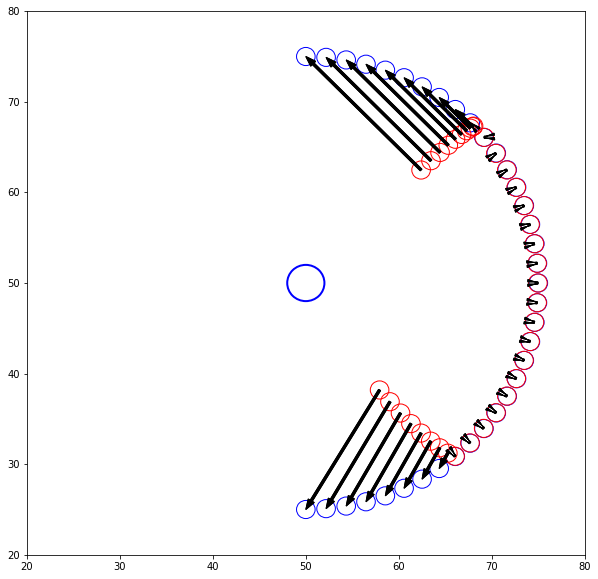

In [10]:
plt.rcParams['figure.figsize'] = [10, 10] 
fig, ax = plt.subplots(1,1)
ax.set_xlim(20,resolution-20)
ax.set_ylim(20,resolution-20)
ax.add_patch(plt.Circle((50,50), radius=2, linewidth=2,edgecolor='blue',facecolor='none'))

for i, tgt in enumerate(targets):
    if i % 5 == 0: 
        ax.add_patch(plt.Circle((tgt[::-1] * resolution/4)+50, radius=1, linewidth=1,edgecolor='blue',facecolor='none'))
for i, ft in enumerate(first_tacks):
    if i % 5 == 0:         
        ax.add_patch(plt.Circle((ft[::-1] * resolution/4)+50, radius=1, linewidth=1,edgecolor='red',facecolor='none'))
for i, st in enumerate(second_tacks):
    if i % 5 == 0:
        ax.add_patch(plt.arrow((first_tacks[i,1]*resolution/4)+50,
                               (first_tacks[i,0]*resolution/4)+50,
                               (st[1]*resolution/4),
                               (st[0]*resolution/4), 
                               width=0.25,edgecolor='k',facecolor='k', length_includes_head = True))
        

As before, we sail out from center. Targets in blue, tack points in red. The arrow shows the second tack direction and length.

* The first tack bearings for wind angles 0-45° are almost the same.

* For bearings in range 45-135° the is no tacking or gybing involved. We sail directly to target.

* For angles 135-180° the first tack bearings again almost the same.

From the boat polars we determined earlier that:
* TWA that maximizes Wind VMG is 44.67°. 
* Downwind TWA that minimizes Wind VMG is 148.25°.

Below the same as a regular chart. Basically it says the same: **If you need to tack, sail the course that maximizes Wind VMG. Give or take few degrees.**

"Few degrees" because if you look closely, you'll notice that the plot is sloping slightly upwards in the 0-45° range. I have a pretty good theory why, but let's leave it for future research.

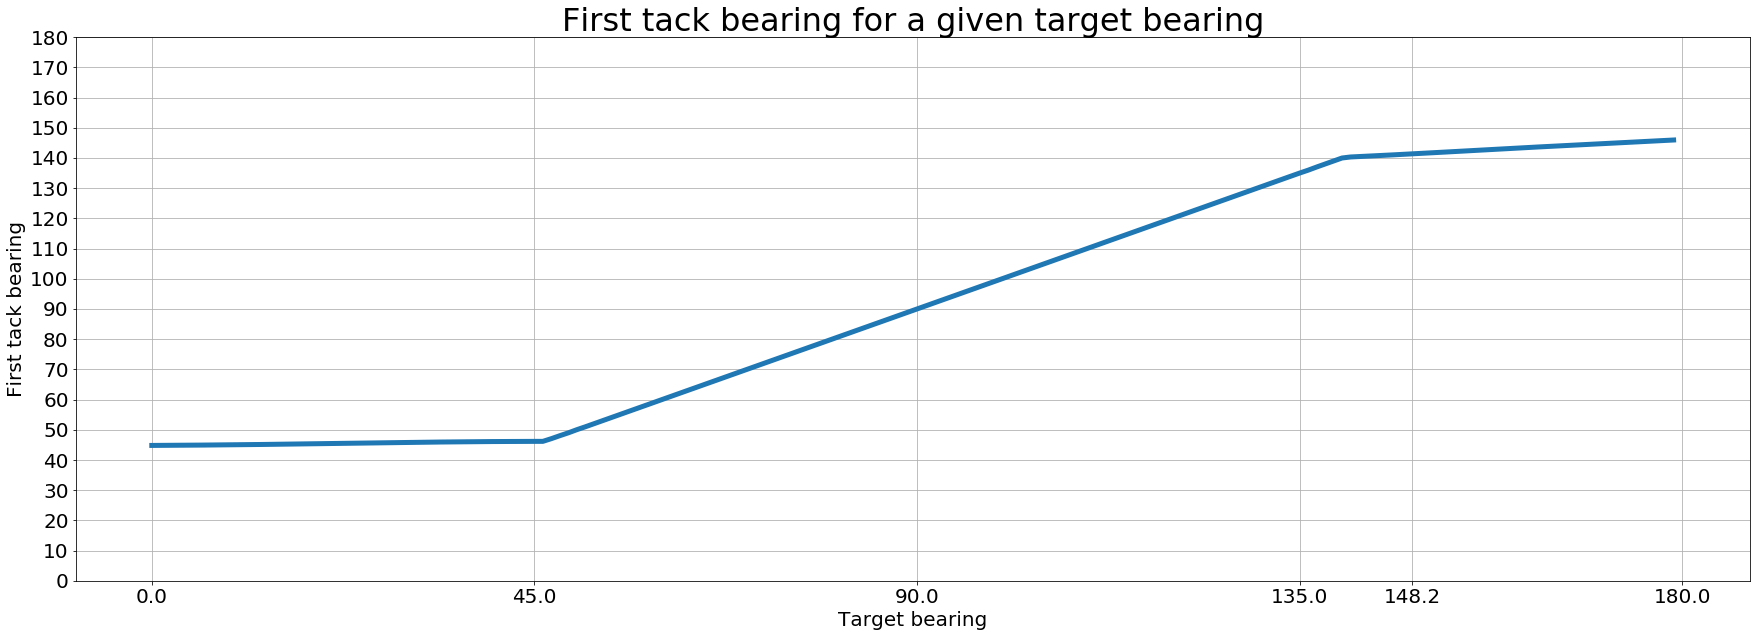

In [17]:
max_vmg = np.zeros(181)
max_vmg[0:180] = upwind_max_vmg_angle.item()*math.pi/180

min_vmg = np.zeros(181)
min_vmg[0:180] = downwind_min_vmg_angle.item()*math.pi/180

plt.rcParams['figure.figsize'] = [30, 10] 
fig, axii = plt.subplots(1,1)
ax = axii

#ax.plot(np.rad2deg(max_vmg[0:180]), linewidth=5)
#ax.plot(np.rad2deg(min_vmg[0:180]), linewidth=5)
ax.plot(np.rad2deg(first_tack_angles[0:180]), linewidth=5)
ax.set_title("First tack bearing for a given target bearing", fontsize=32)
ax.set_yticks(np.arange(0,181,10), minor=False)
ax.set_xticks(np.array([0, 45, 90, 135, 148.25, 180 ]), minor=False)
ax.set_xlabel("Target bearing", fontsize = 20)
ax.set_ylabel("First tack bearing", fontsize = 20)
ax.grid()
for label in (ax.get_xticklabels()+ax.get_yticklabels()):
    label.set_fontsize(20)


## Over and out
Thanks for tagging along.

Below additional charts you may find them interesting.

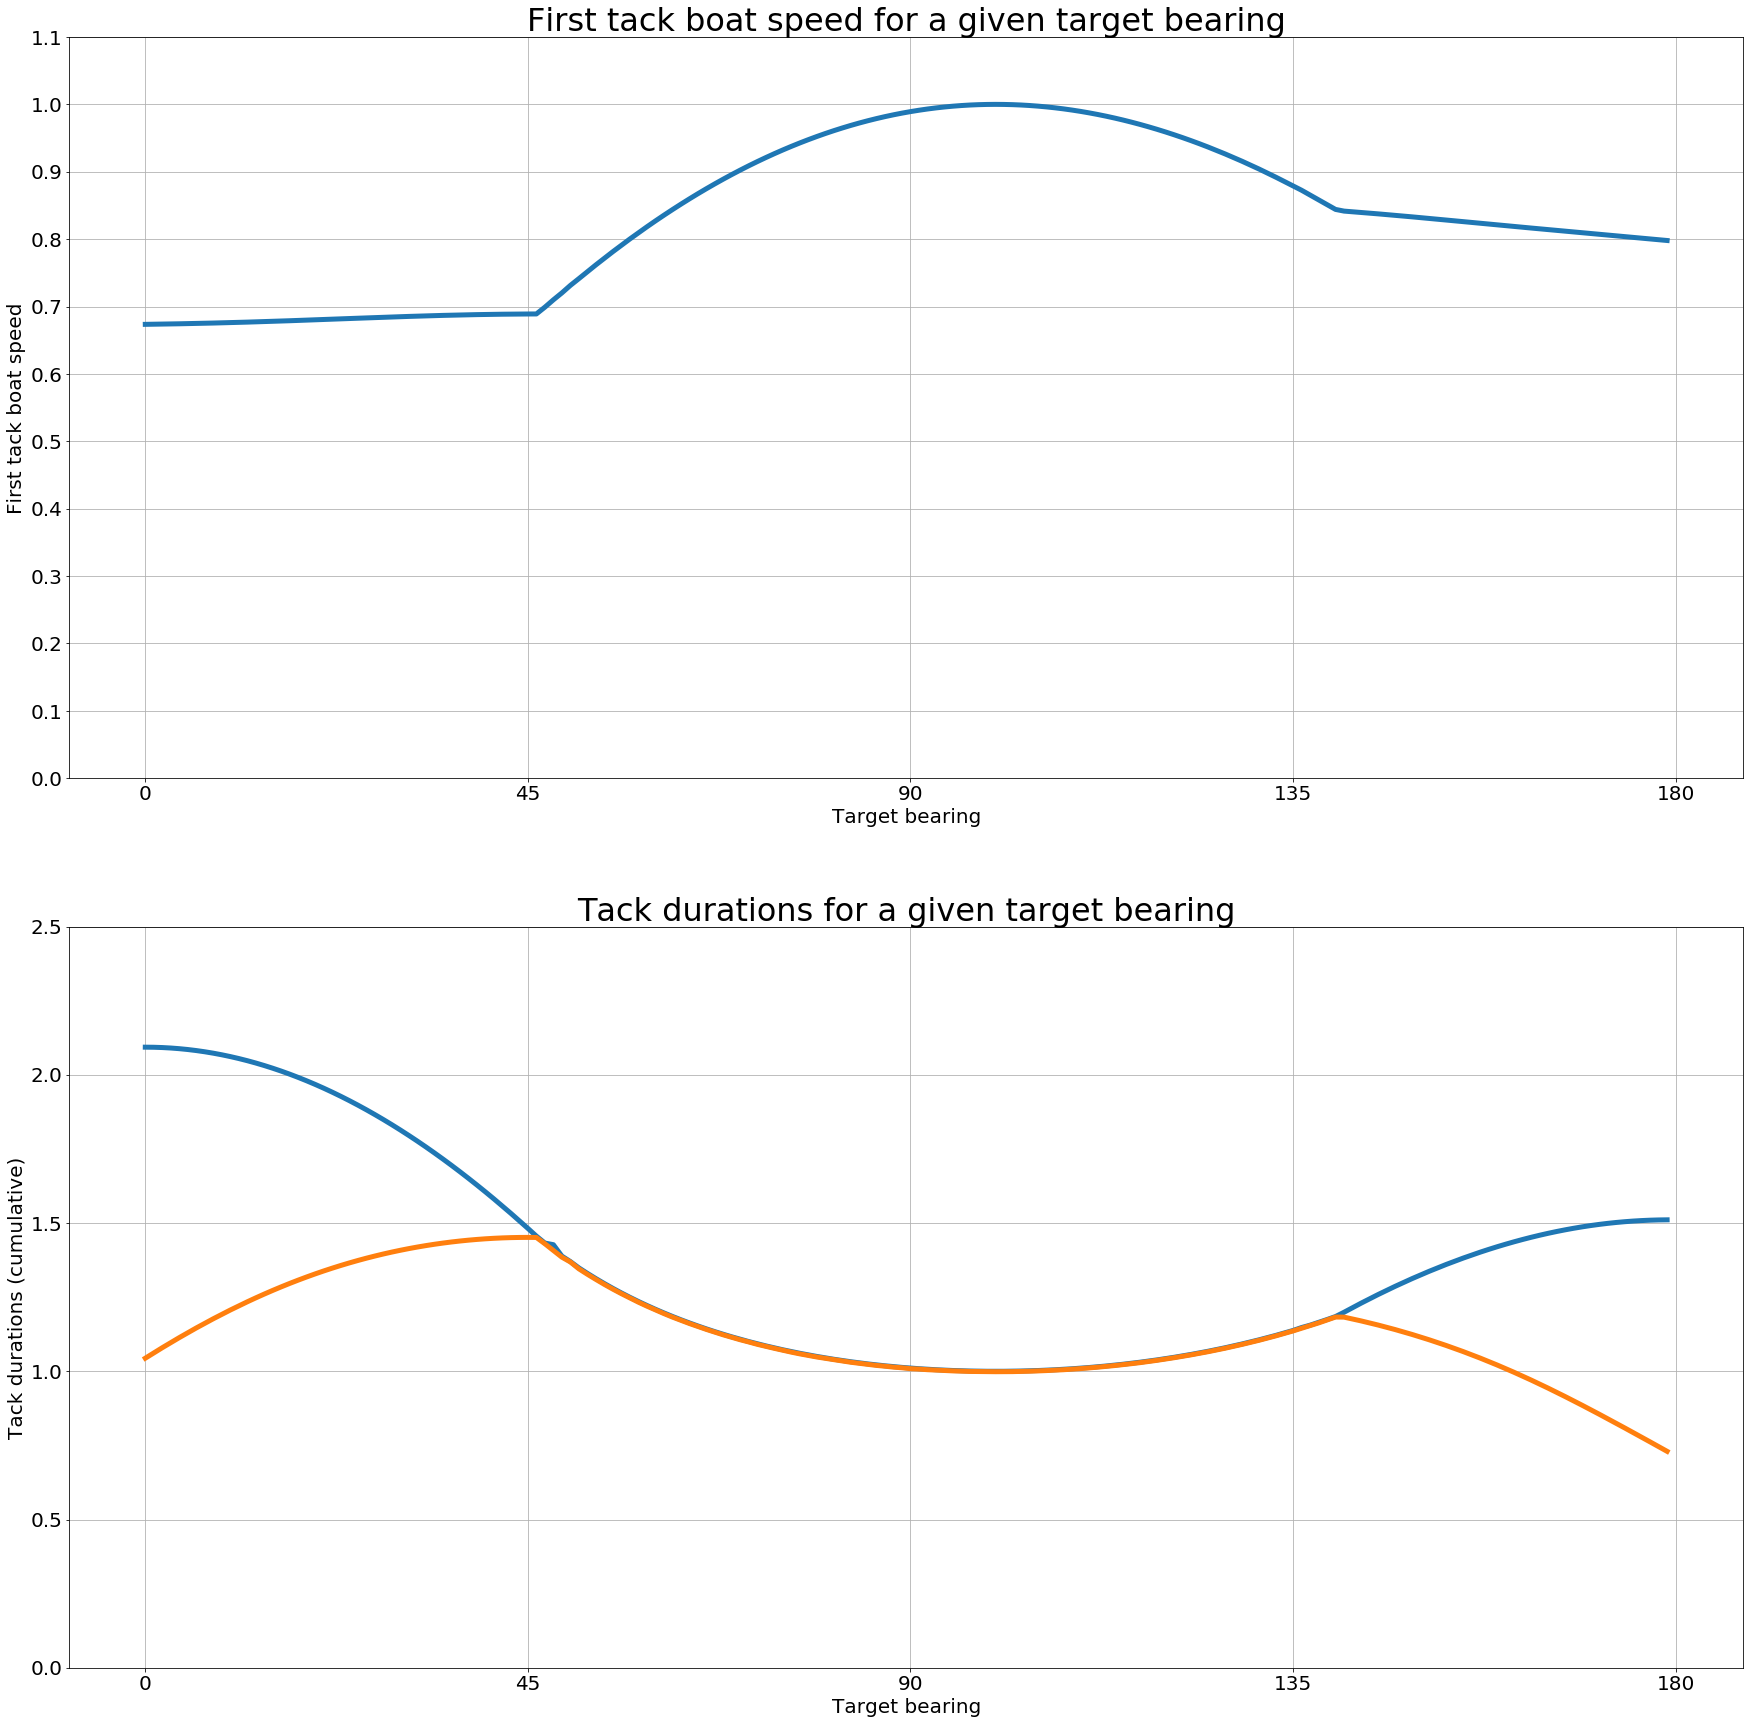

In [12]:
plt.rcParams['figure.figsize'] = [30, 30] 
fig, axii = plt.subplots(2,1)
ax = axii[0]    

#ax.plot(np.rad2deg(max_vmg[0:180]), linewidth=5)
#ax.plot(np.rad2deg(min_vmg[0:180]), linewidth=5)
ax.plot(first_tack_boat_speeds[0:180], linewidth=5)
ax.set_title("First tack boat speed for a given target bearing", fontsize=32)
ax.set_yticks(np.arange(0,1.2,0.1), minor=False)
ax.set_xticks(np.arange(0,181,45), minor=False)
ax.set_xlabel("Target bearing", fontsize = 20)
ax.set_ylabel("First tack boat speed", fontsize = 20)
ax.grid()
for label in (ax.get_xticklabels()+ax.get_yticklabels()):
    label.set_fontsize(20)

    
ax = axii[1]
#ax.plot(np.rad2deg(max_vmg[0:180]), linewidth=5)
#ax.plot(np.rad2deg(min_vmg[0:180]), linewidth=5)
ax.plot(second_tack_durations[0:180] + first_tack_durations[0:180], linewidth=5)
ax.plot(first_tack_durations[0:180], linewidth=5)
ax.set_title("Tack durations for a given target bearing", fontsize=32)
ax.set_yticks(np.arange(0,3,0.5), minor=False)
ax.set_xticks(np.arange(0,181,45), minor=False)
ax.set_xlabel("Target bearing", fontsize = 20)
ax.set_ylabel("Tack durations (cumulative)", fontsize = 20)
ax.grid()
for label in (ax.get_xticklabels()+ax.get_yticklabels()):
    label.set_fontsize(20)    



In [13]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>